# <span style="color:rebeccapurple">Setup</span>

In [2]:
# imports 
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn

# <span style="color:rebeccapurple">Supervised learning - Linear regression</span>

Linear regression model is typically
$$\begin{align}
y = \beta_0 + \sum_{i=1}^N \beta_i x_i
\end{align}$$
where $y$ is the output, $x_i$ are the predictors and $N$ is the number of predictors. What we want to learn is the set of parameters, or weights, $\beta_i, i=0,...N$.

To learn these parameters, sklearn will minimize the residual sum of squares
$$
RSS = (y_{pred} - y_{obs})^2 = (\beta_0 + \sum_{i=1}^N \beta_i x_i - y_{obs})^2
$$
where $M$ is the number of observations.

### I. Data import

In [3]:
# Import a dataset
df = pd.read_csv("data/fish.csv")

<h4><span style="color:blue">Google Colab users only -- un-comment the code lines below and run them to download the dataset and read it</span></h4>

In [ ]:
# !wget https://raw.githubusercontent.com/nuitrcs/scikit-learn-workshop/main/data/fish.csv
# df = pd.read_csv('fish.csv')

In [4]:
df.head()

,species,vertical_len,diag_len,cross_len,height,width,weight
0,Bream,23.2,25.4,30.0,11.5200,4.0200,242.0
1,Bream,24.0,26.3,31.2,12.4800,4.3056,290.0
2,Bream,23.9,26.5,31.1,12.3778,4.6961,340.0
3,Bream,26.3,29.0,33.5,12.7300,4.4555,363.0
4,Bream,26.5,29.0,34.0,12.4440,5.1340,430.0


In [5]:
df.shape

(158, 7)

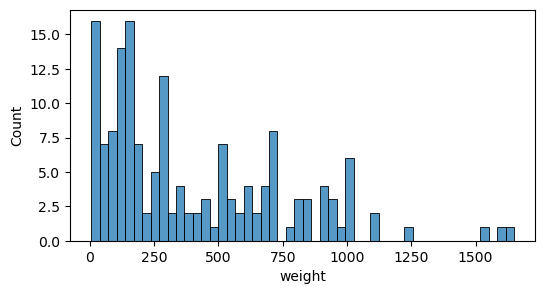

In [6]:
plt.figure(figsize=(6,3))
sns.histplot(df.weight, bins=50)
plt.show()

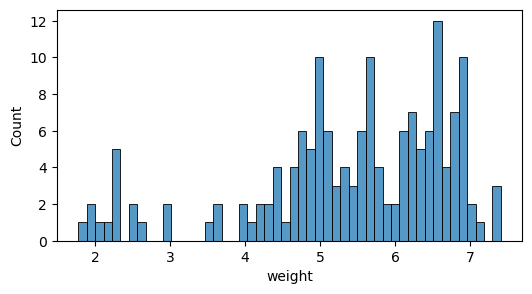

In [7]:
plt.figure(figsize=(6,3))
sns.histplot(df.weight.apply(np.log), bins=50)
plt.show()

In [8]:
df.groupby("species").mean()

,vertical_len,diag_len,cross_len,height,width,weight
species,,,,,,
Bream,30.305714,33.108571,38.354286,15.183211,5.427614,617.828571
Parkki,18.727273,20.345455,22.790909,8.962427,3.220736,154.818182
Perch,25.735714,27.892857,29.571429,7.861870,4.745723,382.239286
Pike,42.476471,45.482353,48.717647,7.713771,5.086382,718.705882
Roach,20.731579,22.368421,25.084211,6.706353,3.673968,160.052632
Smelt,11.257143,11.921429,13.035714,2.209371,1.340093,11.178571
Whitefish,28.800000,31.316667,34.316667,10.027167,5.473050,531.000000


### II. Feature - target split

Suppose we want to predict the weight (in log space) of a fish. We will build a model with the remaining features as predictors.

In [9]:
# separate the input features and the target variable
X = df.drop(columns="weight")
y = np.log(df.weight) # predicting weight in log-scale

X.shape, y.shape

((158, 6), (158,))

### III. Train - test split
Ideally you would split your data into train and test sets before modeling. <br>
I'm doing a 70-30 split.

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((110, 6), (48, 6), (110,), (48,))

### IV. Data pre-processing
Then you would standardize the numeric columns and encode the categorical columns.

### <span style="color:#1409FA">Scaling Numerical data</span>
Several machine learning algorithms rely on calculating distances. Therefore, it is important to have all the input features on the same scale - so that the distances computed for different features are comparable.

#### <span style="color:teal">Scaling features to a range</span>
Apart from standardization, we can scale features to lie between a given minimum and maximum value, often between zero and one. Range compression helps with robustness due to small standard deviations of features after scaling and at the same time preserves zero entries.
$$ x' = \frac{x - min}{max - min} $$

#### <span style="color:teal">Standardization</span>
This is the process of converting data into the standard format where each feature has zero mean and unit variance (i.e., std=1).
$$ x' = \frac{x - \mu}{\sigma}$$

#### I. Find the fit parameters for standardization

In [11]:
# import the class "StandardScaler" from the scikit learn library
from sklearn.preprocessing import StandardScaler

In [12]:
# scaler is an object or instance of class StandardScaler
scaler = StandardScaler()
scaler

StandardScaler()

Hover on the "i" icon - what does it say?

In [13]:
# now feed your data for pre-processing into this object
scaler.fit(X_train)
scaler

ValueError: could not convert string to float: 'Perch'

What happened here? why?

In [14]:
# select only the numeric columns
numeric_cols = ['vertical_len', 'diag_len', 'cross_len', 'height', 'width']

scaler.fit(X_train[numeric_cols])
scaler

StandardScaler()

Hover on the "i" icon - what does it say now? <br>
Once the data is fit, it means that the scaler has calculated the parameters for scaling i.e. the mean and the standard deviation, for each of the numeric columns. However, we still need to calculate the scaled (also called transformed) values (x prime)

$$ x' = \frac{x - \mu}{\sigma}$$

#### II. Transform the train AND test data with the fit paramaters you found

Important note: preprocessing should be fit to train dataset, instead of applying to the whole set, to avoid leakage of information. Data leakage essentially means that the training process has information about, and thus will create a bias toward, the test set, potentially leading to a deceptively good generalization result.

After the preprocessor learns to fit the train dataset, it is then used to transform the train and test set. More specifically, in the case of standardization,the preprocessor will obtain the mean and standard deviation of the train set and use those statistics to transform both the train and test set. As a result, after the transformation, the train set will definitely have 0 mean and unit standard deviation but the test set may not. Why do you think that is?

In [15]:
# get the transformed X_train and X_test data
numeric_X_train = scaler.transform(X_train[numeric_cols])
numeric_X_test  = scaler.transform(X_test[numeric_cols])

Let's see what the transformed data looks like

In [16]:
numeric_X_train_df = pd.DataFrame(data = numeric_X_train, columns= numeric_cols)
display(numeric_X_train_df.head(2))
display(X_train[numeric_cols].head(2))

,vertical_len,diag_len,cross_len,height,width
0,-0.591142,-0.563581,-0.632507,-0.672015,-0.500974
1,0.043097,0.036651,-0.095067,-0.280925,-0.075199


,vertical_len,diag_len,cross_len,height,width
87,20.0,22.0,23.5,6.1100,3.5250
105,25.9,28.0,29.4,7.8204,4.2042


In [17]:
numeric_X_train_df.describe().loc["mean"]

vertical_len   -7.191217e-17
diag_len        4.072500e-16
cross_len       1.817990e-16
height          6.427939e-17
width           2.397072e-16
Name: mean, dtype: float64

What do you notice about the mean of the transformed values?

In [18]:
numeric_X_train_df.describe().loc["std"]

vertical_len    1.004577
diag_len        1.004577
cross_len       1.004577
height          1.004577
width           1.004577
Name: std, dtype: float64

What do you notice about the standard deviation of the transformed values?

### <span style="color:#1409FA">Encoding Categorical data</span>
Data sometimes come in non-numeric values in predictors and/or response.

#### <span style="color:teal">Ordinal encoding</span>
This is the process of assigning each unique category an integer value. Doing this, we impose a natural ordered relationship between each category.

For example, age is ordered in nature and we can map the different ranges to integer values. More specifically, 30-39 => 0, 40-49 =>1, 50-59 => 2, etc.

#### <span style="color:teal">One-hot encoding</span>
When there is no natural ordinal relationship among different categories, OrdinalEncoder is not an appropriate approach.

In addition, when the response variable has no ordinal relationship, encoding its labels as ordered integer values can result in poor performance. For example, suppose we encode the response's labels as 0, 1, 2. The algorithm can return a prediction of 1.5.

One-hot encoding is the process of transforming each label of the orginal categorical variable into a new binary variable. This means the total number of features will increase after preprocessing.

#### I. Find the fit parameters for standardization

In [19]:
# import the class "OneHotEncoder" from the scikit learn library
from sklearn.preprocessing import OneHotEncoder

In [20]:
# create object/instance of class OneHotEncoder
ohe = OneHotEncoder()

In [21]:
# now feed your categorical columns of train X for pre-processing into this object
categorical_cols = ['species']

ohe.fit(X_train[categorical_cols])

OneHotEncoder()

#### II. Transform the train AND test data with the fit paramaters you found

In [22]:
# transform both train and test
ohe_X_train = ohe.transform(X_train[categorical_cols]) # transform train set
ohe_X_test = ohe.transform(X_test[categorical_cols])   # transform test set

In [23]:
ohe_X_train

<110x7 sparse matrix of type '<class 'numpy.float64'>'
	with 110 stored elements in Compressed Sparse Row format>

In [24]:
# convert to an array
ohe_X_train = ohe_X_train.toarray()
ohe_X_test = ohe_X_test.toarray()

ohe_X_train.shape, ohe_X_test.shape

((110, 7), (48, 7))

In [26]:
# ---------------- stack the processed columns together---------------
processed_X_train = np.hstack( (numeric_X_train, ohe_X_train) )
processed_X_test = np.hstack((numeric_X_test, ohe_X_test))

processed_X_train.shape, processed_X_test.shape

((110, 12), (48, 12))

### <span style="color:#1409FA">Putting it all together</span>

In [ ]:
numeric_cols = ['vertical_len', 'diag_len', 'cross_len', 'height', 'width']
categorical_cols = ['species']

In [ ]:
# process the numeric columns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()           # generate instance
scaler.fit(X_train[numeric_cols])   # fit the scaler with train X

# get the transformed X_train and X_test data
numeric_X_train = scaler.transform(X_train[numeric_cols])
numeric_X_test  = scaler.transform(X_test[numeric_cols])

numeric_X_train.shape, numeric_X_test.shape

In [ ]:
# process the categorical columns
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()               # generate instance
ohe.fit(X_train[categorical_cols])  # fit the encoder with train X

# get the transformed X_train and X_test data
ohe_X_train = ohe.transform(X_train[categorical_cols]) # transform train set
ohe_X_test = ohe.transform(X_test[categorical_cols])   # transform test set

# convert to array
ohe_X_train = ohe_X_train.toarray()
ohe_X_test = ohe_X_test.toarray()

ohe_X_train.shape, ohe_X_test.shape

In [ ]:
# use hstack to join the separately processed columns back together
processed_X_train = np.hstack((numeric_X_train, ohe_X_train))
processed_X_test = np.hstack((numeric_X_test, ohe_X_test))

processed_X_train.shape, processed_X_test.shape

### V. Modeling

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression() # create an instance of class "LinearRegression"

In [ ]:
# fit the model to your data features and labels
model.fit(processed_X_train, y_train)

In [ ]:
# look at the model results
model.intercept_, np.exp(model.intercept_)

In [ ]:
model.coef_

In [ ]:
model.coef_.shape

In [ ]:
feature_names = numeric_cols + list(ohe.categories_[0])
len(feature_names)

In [ ]:
# get the model coefficients inside a nice dataframe which includes the input feature names
feature_names = numeric_cols + list(ohe.categories_[0])
coefs = pd.DataFrame(data=model.coef_, 
                     columns=["Coefficients"], 
                     index=feature_names,)

In [ ]:
coefs

In [ ]:
# plot the model coefficient
coefs.plot.barh(figsize=(10, 4))
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient values")
plt.subplots_adjust(left=0.3)

From this plot, we would infer that the important factors in determining weight of a fish are: whether it is a smelt, and the vertical and diagnoal length of the fish. 

Comparing weight based on their magnitude to determine feature importance can be misleading if features vary widely, i.e., their variances/standard deviations are of different scale. However, we already standardize our dataset and eliminate this concern. Thus, it is relatively safe to make the inference above.

### VI. Prediction

In [ ]:
y_predicted_train = model.predict(processed_X_train)
y_predicted_test = model.predict(processed_X_test)

y_predicted_train.shape, y_predicted_test.shape

In [ ]:
y_predicted_test

In [ ]:
# let's compare our predicted weights to the observed weights
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

axes[0].scatter(y_train, y_predicted_train, s=2)
axes[0].set_title("Train data")
axes[1].scatter(y_test, y_predicted_test, s=2)
axes[1].set_title("Test data")

for ax in axes:
    ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c="red")
    ax.set(xlabel="Observed weight", ylabel="Predicted weight")

### VII. Model evaluation

We are interested in understanding how well the learned model generalizes. There are several metrics to quantify the quality of a model.

A typical measure for regression is the mean squared error
$$
MSE = \frac{1}{M} (y_{pred} - y_{obs})^2
$$

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mse = mean_squared_error(y_test, y_predicted_test)
print("test MSE - ", mse)

In [ ]:
mse = mean_squared_error(y_train, y_predicted_train)
print("train MSE - ", mse)

Another measure is $R^2$ score, which indicates a goodness of fit. More specifically, it represents the proportion of the response's variance that has been explained by the predictors. Best possible score is 1.

In [ ]:
from sklearn.metrics import r2_score

In [ ]:
r2_score(y_test, y_predicted_test)

<span style="color:#DC537D"><font size="+1">Does it matter if train error is much smaller than test error? Why or why not?</font></span>